 ![logo][gfzlogo]
 
 #   ENHANS -   Exposure modelling Workshop   -  May 2017
 
 ---
 
 
 ## 5.1 - Building Typology Assignment
 
 
 ---

 


[gfzlogo]:gfz_logo2.jpg

## language: Python 2.7

### first: Load packages

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from string import Template
import matplotlib.pyplot as plt
%matplotlib inline
#from lxml import etree
from sqlalchemy import create_engine
from sqlalchemy.sql import text

#used by the nrml 
NAMESPACE = 'http://openquake.org/xmlns/nrml/0.5'
GML_NAMESPACE = 'http://www.opengis.net/gml'
SERIALIZE_NS_MAP = {None: NAMESPACE, 'gml': GML_NAMESPACE}


# Query of building data from the database

the data is fetched from the database (either local or from remote) using a SQL query. 

In our case we retrieve the following information:

- latitude (of the centroid of the building)
- longitude (of the centroid of the building)
- ID of the building (same as used in the RRVS interface)
- mat_type: material type
- mat_tech: material technology
- mat_prop: material properties
- llrs: lateral load resisting system
- llrs_duct: ductility of the lateral load resisting system
- height: height, typology of observation
- height_1: height, value
- height_2: height, optional second value (for intervals)
- yr_built: year of construction
- occupy: type of occupancy
- occupy_dt: detail on the occupancy
- str_irreg: structural irregularities
- str_irreg_dt: detail on the structural irregularities
- str_irreg_type: type of structural irregularities
- roof_shape: shape of the roof
- roofcovmat: material of the roof cover
- roofsysmat: material of the roof structural system 
- roofsystyp: type of roof structural system
- roof_conn: type of roof connection
- floor_mat: material of the floors
- floor_type: type of the floors
- floor_conn: type of floors connection 

##Exercise 1
Query different attribute types from the database

##Exercise 2
Include a spatial query. Are boundary data defined ?

In [4]:
engine = create_engine('postgresql://postgres@localhost:5432/rem')

## Query data, option 1: use the integrated view

In [22]:
# query to the database
tt=pd.read_sql_query("select \
st_x(st_transform(st_centroid(v.the_geom),4326)) lon,\
st_y(st_transform(st_centroid(v.the_geom),4326)) lat,\
v.object_id,\
v.mat_type,\
v.mat_tech,\
v.mat_prop,\
v.llrs,\
v.llrs_duct,\
v.height,\
v.height_1,\
v.height_2,\
v.yr_built,\
v.occupy,\
v.occupy_dt,\
v.str_irreg,\
v.str_irreg_dt,\
v.str_irreg_type,\
v.roof_shape,\
v.roofcovmat,\
v.roofsysmat,\
v.roofsystyp,\
v.roof_conn,\
v.floor_mat,\
v.floor_type,\
v.floor_conn \
from asset.ve_object v where v.survey_gid={} and v.rrvs_status = '{}';".format(6,'COMPLETED'),con=engine)

#test
tt.head()

,lon,lat,object_id,mat_type,mat_tech,mat_prop,llrs,llrs_duct,height,height_1,...,str_irreg_dt,str_irreg_type,roof_shape,roofcovmat,roofsysmat,roofsystyp,roof_conn,floor_mat,floor_type,floor_conn
0,-70.577729,-33.424385,85990,CR,CIP,MO99,L99,DU99,H,3.0,...,IRP99,IRT99,RSH1,RMT99,RC,RST99,RCN99,FC,FT99,FWC99
1,-70.580129,-33.425516,86011,MAT99,MATT99,MO99,L99,DU99,H,7.0,...,IRP99,IRT99,RSH1,RMN,RC,RST99,RCN99,F99,FT99,FWC99
2,-70.578634,-33.424760,86019,CR,CIP,MATP99,LWAL,DU99,H,6.0,...,IRP99,IRN,RSH1,RMT99,RSM99,RST99,RCN99,FC,FT99,FWCP
3,-70.578400,-33.424983,86020,CU,CIPPS,MATP99,LWAL,DU99,H,3.0,...,IRP99,IRT99,RSH1,RMT99,RSM99,RST99,RCN99,FC,FT99,FWC99
4,-70.578265,-33.425174,86021,CR,CIP,MO99,L99,DU99,H99,99.0,...,IRP99,IRT99,RSH1,RMT99,RSM99,RST99,RCN99,FC,FT99,FWC99


## Query data, option 2: use a 'crosstab'

In [13]:
# query to the database
def get_exp_raw(engine,survey,status):
    
    sql = """
select ct.*, oa.attribute_numeric_1 height_1  from crosstab(
   'select oa.object_id, oa.attribute_type_code, oa.attribute_value
    from asset.object_attribute as oa  order by 1,2;') 
    as ct(object_id integer,build_subtype varchar,
build_tpye varchar,
comment varchar,
floor_conn varchar,
floor_mat varchar,
floor_type varchar,
foundn_sys varchar,
height varchar,
height2 varchar,
llrs varchar,
llrs_duct varchar,
mat_prop varchar,
mat_tech varchar,
mat_type varchar,
nonstrcexw varchar,
occupy varchar,
occupy_dt varchar,
plan_shape varchar,
position varchar,
roof_conn varchar,
roof_covmat varchar,
rooof_shape varchar,
roof_sysmat varchar,
roofsystyp varchar,
rrvs_status varchar,
str_irreg varchar,
str_irreg_2 varchar,
str_irreg_dt varchar,
str_irreg_dt_2 varchar,
str_irreg_type varchar,
str_irreg_type_2 varchar,
vuln varchar,
yr_built varchar
), asset.object_attribute oa, asset.object o 
where oa.object_id = ct.object_id and oa.attribute_type_code='HEIGHT' 
and ct.rrvs_status='{}' and o.gid = ct.object_id and o.survey_gid={};
  """.format(status,survey)

    t=pd.read_sql_query(sql,con=engine)
    return t

#test
tt = get_exp_raw(engine, 6,'COMPLETED')

#Structural features defining the building types

We specify which structural features are considered in order to assign a building type, and which weight has the particular attribute type within the assignment process.

We do it using a python "dictionary" {key:value} construct, where the keys are the considered attributes and the values are the related weights. 

If these features provide an exhaustive description, the sum should sum up to one.

In [21]:
tt

NameError: name 'tt' is not defined

In [13]:
#define the weight of attributes as a dictionary
wgs = {
    'mat_type':0.35,
    'mat_tech':0.25,
    'mat_prop':0.05,
    'llrs':0.2,
    'llrs_duct':0.05,
    'floor_mat':0.1
    }

#are they exhaustive? if so, they should sum up to 1
sum(wgs.values())

1.0

#Definition of the building typologies

Each building typology is defined by listing, for each attribute type considered (see above), a set of compatibile attribute values, each with a specific 'score'  $s$.





In [18]:
# define the building types
# define the weight of values for each attribute and each building type

bmod={}
#TYPE 1: MUR+CLBRS+MOC/LWAL+DNO/FW/H_BET:1:3
bmod['MUR1']={}
bmod['MUR1']['mat_type']= {'MUR':1,'M99':0.8,'MAT99':0}
bmod['MUR1']['mat_tech']={'CLBRS':1,'CLBRH':1,'MATT99':0}
bmod['MUR1']['mat_prop']={'MOC':1,'MATP99':0}
bmod['MUR1']['llrs']={'LWAL':1,'L99':0}
bmod['MUR1']['llrs_duct']={'DNO':1,'DU99':0}
bmod['MUR1']['floor_mat']={'FW':1,'F99':0}
bmod['MUR1']['height_1']={'H_MIN':1,'H_MAX':3}

#TYPE 2: CR+PC+MOC/LFLS+DUC/FC/H_BET:5:9
bmod['RC1']={}
bmod['RC1']['mat_type']= {'CR':1,'C99':0.5,'MAT99':0}
bmod['RC1']['mat_tech']={'PC':1,'MATT99':0}
bmod['RC1']['mat_prop']={'MOC':1,'MATP99':0}
bmod['RC1']['llrs']={'LFLS':1,'L99':0}
bmod['RC1']['llrs_duct']={'DUC':1,'DU99':0}
bmod['RC1']['floor_mat']={'FC':1,'F99':0}
bmod['RC1']['height_1']={'H_MIN':5,'H_MAX':9}

#TYPE 3: W+WO+SPBA///H_BET:1:5
bmod['WOOD1']={}
bmod['WOOD1']['mat_type']= {'W':1,'MAT99':0}
bmod['WOOD1']['mat_tech']={'WO':1,'MATT99':0}
bmod['WOOD1']['mat_prop']={'SPBA':1,'MATP99':0}
bmod['WOOD1']['llrs']={'L99':0}
bmod['WOOD1']['llrs_duct']={'DU99':0}
bmod['WOOD1']['floor_mat']={'F99':0}
bmod['WOOD1']['height_1']={'H_MIN':1,'H_MAX':5}

#TYPE 4: W+WBB+SPBA///H_BET:1:5
bmod['WOOD2']={}
bmod['WOOD2']['mat_type']= {'W':1,'MAT99':0}
bmod['WOOD2']['mat_tech']={'WBB':1,'MATT99':0}
bmod['WOOD2']['mat_prop']={'MATP99':0}
bmod['WOOD2']['llrs']={'L99':0}
bmod['WOOD2']['llrs_duct']={'DU99':0}
bmod['WOOD2']['floor_mat']={'F99':0}
bmod['WOOD2']['height_1']={'H_MIN':1,'H_MAX':5}


#Computing the building scores

* * *

For each building is then assigned a score $S$ defined as:

$$ S(b) = \sum_i w_i ( \sum_k \delta_{ik}(b) s_k) $$

where

$$   
\delta_{ik}(b) =\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ v_k \in B(b) \\
    0, & \text{otherwise}
  \end{array}\right.
$$

The score $S$ is then subject to constraints $C$

$$ S(b) = S(b) \prod_i \delta_{i}(b)$$

where

$$   
\delta_{i}(b) =\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ C_i \ \text{is satisfied}\ \\
    0, & \text{otherwise}
  \end{array}\right.
$$

---

In this case, a single constraint can be defined for the height. 

In case the constrain is considered too a strong filtering, it can be considered as an additional weighted component (see calculation below)

In [19]:
# function that computes the score of a building for a building type
def compute_single_bscore(bdg,btype):
    #compute the score
    a=[bmod[btype][k].get(bdg[k],-1) for k in wgs.keys()]
    s1 = np.dot(a,wgs.values())
    #check the additional attribute, in this case the height
    ch1 = ((bdg['height_1'] >= bmod[btype]['height_1']['H_MIN']) & (bdg['height_1'] <= bmod[btype]['height_1']['H_MAX']))
    
    #apply the constrain
    #s = s1*ch1
    #alternative: use the constrain with a weight
    #s = s1+ch1*(1-sum(wgs.values()))
    s = s1*ch1

    
    return s

# compute the score of a building for all defined building types
def compute_bscore(bdg):
    #res = pd.DataFrame(columns=bmod.keys())
    res={}
    for bt in bmod.keys():
        res[bt]=compute_single_bscore(bdg,bt) 
        res['object_id']=bdg['object_id']
        
    return res

# Building type assignment

once the scores are computed for each building, we can assign the building type with the highest score.

## Caution
if the scores are all equal, or very low, the assignment may be misleading. Its therefore better to set a threshold for the score (e.g. $S\ge 0$), or a more sophisticaed solution.



In [23]:
#test
bdgs = tt[tt['mat_type']!='MAT99']

scores = pd.DataFrame([compute_bscore(b) for i,b in bdgs.iterrows()])

# assign to each building the argmax of the score
scores['btype']=scores[bmod.keys()].idxmax(1)

# set a flag to 'true' for the buildings whose best score is >=0
scores['valid']=scores.apply(lambda df:df[df['btype']]>0, 1)

#select only the valid ones
scores[scores['valid']]


,MUR1,RC1,WOOD1,WOOD2,object_id,btype,valid
4,-0.00,0.10,-0.00,-0.00,86022,RC1,True
5,-0.00,0.15,-0.00,-0.00,86075,RC1,True
10,-0.00,0.25,-0.75,-0.75,86105,RC1,True
14,-0.00,0.15,-0.00,-0.00,86147,RC1,True
16,-0.00,0.15,-0.00,-0.00,86167,RC1,True
21,-0.00,0.25,-0.75,-0.75,86201,RC1,True
23,-0.00,0.15,-0.00,-0.00,86227,RC1,True
33,-0.00,0.15,-0.00,-0.00,86394,RC1,True
36,-0.00,0.15,-0.00,-0.00,86512,RC1,True
39,0.33,-0.00,-0.90,-0.90,86517,MUR1,True


## Now we can merge the building assignment with the original data

Only the data considered valid are taken into account

In [24]:
expo_df = pd.merge(tt[['object_id','mat_type','mat_tech','mat_prop']],
         scores[scores['valid']][['object_id','btype']], how='inner', on='object_id')

expo_df

,object_id,mat_type,mat_tech,mat_prop,btype
0,86022,CR,CBS,MOC,RC1
1,86075,CR,CB99,MOC,RC1
2,86105,CR,CB99,MOC,RC1
3,86147,CR,CIP,MO99,RC1
4,86167,CR,CBH,MO99,RC1
5,86201,CR,CBS,MOC,RC1
6,86227,CR,CIP,MO99,RC1
7,86394,CR,CIP,MO99,RC1
8,86512,CR,CIP,MO99,RC1
9,86517,M99,MUN99,MOC,MUR1


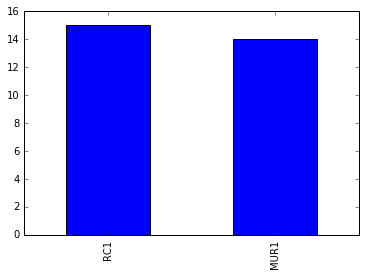

In [25]:
expo_df['btype'].value_counts().plot(kind='bar')

## ... and write back the processed data into the database

In [26]:
#sql query to join the processed table with the information in the rrvs database
sqltempquery = Template('drop table if exists $tablename;\
create table $tablename as \
select v.*, p.btype \
from asset.ve_object v inner join $tablename_tmp p \
on v.object_id = p.object_id;\
drop table if exists $tablename_tmp;')

# function to export the processed building information to the database
def export_database(df, tablename):
    sql_pars=dict(tablename ='{}'.format(tablename),
                  tablename_tmp = '{}_tmp'.format(tablename))
    engine.execute(text("drop table if exists {};".format(sql_pars['tablename_tmp'])))
    df.to_sql(sql_pars['tablename_tmp'],engine)
    t = sqltempquery.substitute(sql_pars)
    engine.execute(text(t))

# create the processed table in the public schema of the database
export_database(expo_df,'proc_expo')

##Exercise
The resulting model can now be queried from the database and mapped using QGIS. Try this out!

